Assignment 5

Pranav K Nayak: ES20BTECH11035

Problem 1: DDPG

In [22]:
# Imports
import gymnasium as gym
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random


a) Load the environment and explore using a random agent

In [23]:
# Load MountainCar and LunarLander environments
mc_env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
ll_env = gym.make('LunarLander-v2', continuous = True, render_mode='rgb_array')


In [24]:
print(f"MountainCar - State Space: {mc_env.observation_space}] Action Space {mc_env.action_space}]" )
print(f"LunarLander - State Space: {ll_env.observation_space}] Action Space {ll_env.action_space}]" )
# Since both environments have finite elements for their action spaces, using the built-in sample() method results in uniformly random actions being sampled


MountainCar - State Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)] Action Space Box(-1.0, 1.0, (1,), float32)]
LunarLander - State Space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)] Action Space Box(-1.0, 1.0, (2,), float32)]


In [25]:
# Random agent for MountainCar
state = mc_env.reset()
rewards = {}
for epoch in range(5):
    done = False
    terminated = False
    while not done and not terminated:
        counts = {}
        action = mc_env.action_space.sample()
        state, reward, done, terminated, _ = mc_env.step(action)
        if action.item() in rewards.keys():
            rewards[action.item()] += reward
            counts[action.item()] += 1
            rewards[action.item()] /= counts[action.item()]
        else:
            rewards[action.item()] = reward
            counts[action.item()] = 1

ll_env.close()


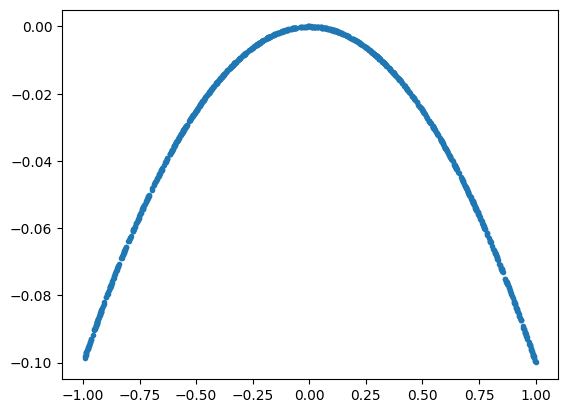

In [26]:
plt.scatter(rewards.keys(), rewards.values(), marker='.')


In [27]:
# Random Agent for Lunar Lander
state = ll_env.reset()
rewards = {}
for epoch in range(100):
    done = False
    terminated = False
    while not done and not terminated:
        counts = {}
        action = ll_env.action_space.sample()
        state, reward, done, terminated, _ = ll_env.step(action)
        x, y = state[0], state[1]
        if (x, y) in rewards.keys():
            rewards[(x, y)] += reward
            counts[(x, y)] += 1
            rewards[(x, y)] /= counts[action.item()]
        else:
            rewards[(x, y)] = reward
            counts[(x, y)] = 1


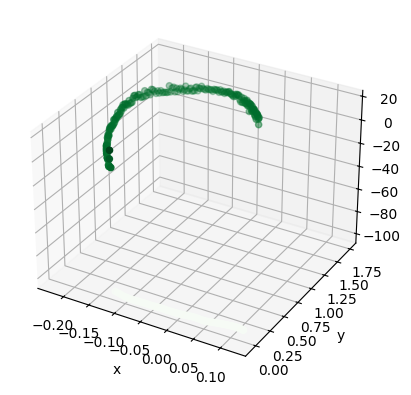

In [28]:
x = []
y = []
z = []
for key in rewards.keys():
    x.append(key[0])
    y.append(key[1])
    z.append(rewards[key])
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=z, cmap='Greens')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


In [29]:
# Network definitions
class Critic(nn.Module):
  def __init__(self, env) -> None:
    super().__init__()
    self.fc1 = nn.Linear(np.prod(env.observation_space.shape) + np.prod(env.action_space.shape), 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 1)

  def forward(self, state, action):
    x = torch.cat([state, action], dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

class Actor(nn.Module):
  def __init__(self, env):
    super().__init__()
    self.fc1 = nn.Linear(np.prod(env.observation_space.shape), 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc_pi = nn.Linear(256, np.prod(env.action_space.shape))
    # Optional?
    self.register_buffer('action_scale', torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float))
    self.register_buffer('action_bias', torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float))

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    x = torch.tanh(self.fc_pi(x))
    return x * self.action_scale + self.action_bias


In [30]:
# Replay buffer definition
class ReplayBuffer:

  def __init__(self, env):
    self.s_buf = np.empty((0, np.prod(env.observation_space.shape)), dtype=np.float32)
    self.sprime_buf = np.empty((0, np.prod(env.observation_space.shape)), dtype=np.float32)
    self.a_buf = np.empty((0, np.prod(env.action_space.shape)), dtype=np.float32)
    self.r_buf = np.empty((0, 1), dtype=np.float32)
    self.done_buf = np.empty((0, 1), dtype=np.float32)
    self.size = 0

  def store(self, s, a, r, sprime, done):
    self.s_buf = np.vstack((self.s_buf, s))
    self.a_buf = np.vstack((self.a_buf, a))
    self.r_buf = np.vstack((self.r_buf, r))
    self.sprime_buf = np.vstack((self.sprime_buf, sprime))
    self.done_buf = np.vstack((self.done_buf, done))
    self.size += 1

  def sample_batch(self, batch_size=32):
    ids = np.random.randint(0, self.size, size=batch_size)
    return self.s_buf[ids], self.a_buf[ids], self.r_buf[ids], self.sprime_buf[ids], self.done_buf[ids]

  def __len__(self):
    return self.size


MountainCar Continuous

In [31]:
# Seeding
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [32]:
mc_env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
actor = Actor(mc_env).to(device)
critic = Critic(mc_env).to(device)
target_actor = Actor(mc_env).to(device)
target_critic = Critic(mc_env).to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-4)


In [33]:
# Noise param definitions
theta = 1
sigma = 10
mu = 0.1


In [34]:
# Prepopulate the replay buffer with a 1000-length trajectory sampled from the uniform random policy
rb  = ReplayBuffer(mc_env)
state, _ = mc_env.reset(seed=42)
while len(rb) < 1000:
  with torch.no_grad():
    # action = actor(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)).squeeze(0).cpu().numpy()
    action = mc_env.action_space.sample()
    a_noise = theta * (mu - action) + sigma * np.random.randn(*action.shape)
    action = np.clip(action + a_noise, mc_env.action_space.low, mc_env.action_space.high)
    sprime, reward, done, _, _ = mc_env.step(action)
    rb.store(state, action, reward, sprime, done)
    state = sprime

# Training Loop
EPOCHS = 1000
batch = 64
policy_update = 10
checkpoint = 50
tau = 0.005
actor_losses = []
critic_losses = []
s, _ = mc_env.reset(seed=42)
for ep in range(1, (EPOCHS+1)):
  with torch.no_grad():
    s, _, _, _, _ = rb.sample_batch(1)
    a = actor(torch.tensor(s, dtype=torch.float, device=device)).cpu().numpy().squeeze(0)
    a_noise = theta * (mu - a) + sigma * np.random.randn(*a.shape)
    a = np.clip(a + a_noise, mc_env.action_space.low, mc_env.action_space.high)
    sprime, r, done, _, _ = mc_env.step(a)
    rb.store(s, a, r, sprime, done)

  s, a, r, sprime, done = rb.sample_batch(batch)
  s = torch.tensor(s, dtype=torch.float32, device=device)
  a = torch.tensor(a, dtype=torch.float32, device=device)
  r = torch.tensor(r, dtype=torch.float32, device=device)
  sprime = torch.tensor(sprime, dtype=torch.float32, device=device)
  done = torch.tensor(done, dtype=torch.float32, device=device)




  a_prime = target_actor(sprime)
  q_next_target = target_critic(sprime, a_prime)
  q_target = r + q_next_target * (1.0 - done) # Undiscounted

  q = critic(s, a)
  q_loss = F.mse_loss(q, q_target)

  critic_optimizer.zero_grad()
  q_loss.backward()
  critic_optimizer.step()
  critic_losses.append(q_loss.item())

  if ep % policy_update == 0:
    actor_loss = -critic(s, actor(s)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    actor_losses.append(actor_loss.item())
    # Saving checkpoints:
  if ep % checkpoint == 0:
    torch.save({
      'epoch': ep,
      'actor_state_dict': actor.state_dict(),
      'critic_state_dict': critic.state_dict(),
      'actor_optimizer_state_dict': actor_optimizer.state_dict(),
      'critic_optimizer_state_dict': critic_optimizer.state_dict(),
      'actor_loss': actor_loss,
      'critic_loss': q_loss,
    }, f'mc_checkpoints/epoch_{ep}.pt')


  # Polyak averaging
    for weight, target_weight in zip(actor.parameters(), target_actor.parameters()):
      target_weight.data.copy_(tau * weight.data + (1.0 - tau) * target_weight.data)
    for weight, target_weight in zip(critic.parameters(), target_critic.parameters()):
      target_weight.data.copy_(tau * weight.data + (1.0 - tau) * target_weight.data)


Text(0.5, 1.0, 'Critic Loss')

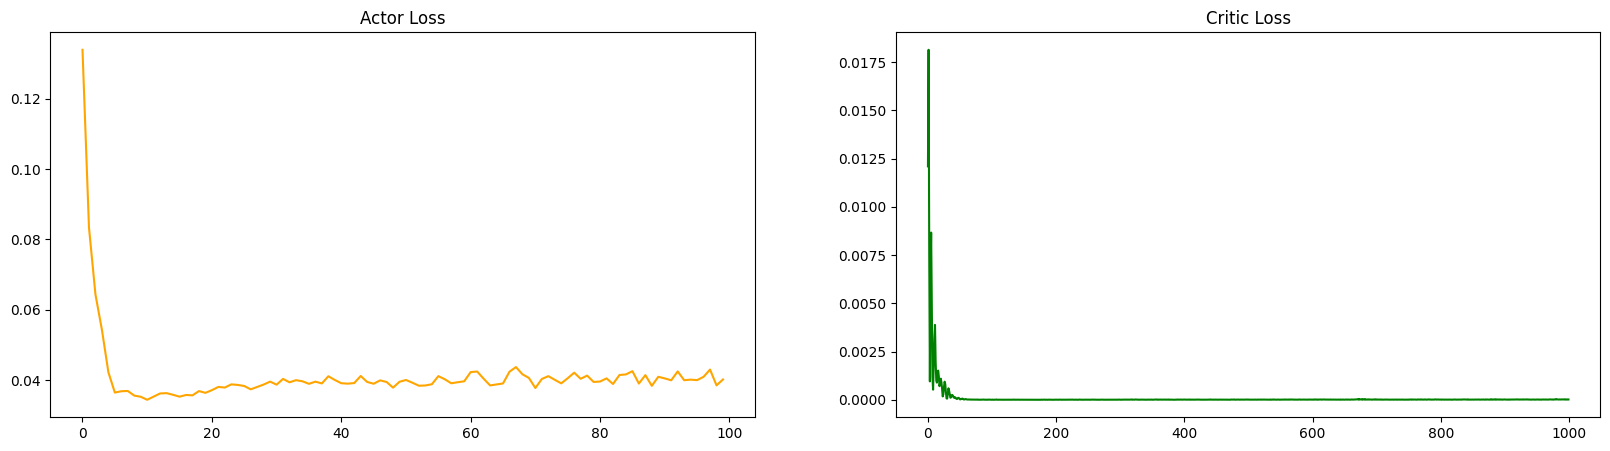

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(actor_losses, c='orange')
axs[0].set_title('Actor Loss')
axs[1].plot(critic_losses, c='g')
axs[1].set_title('Critic Loss')


In [36]:
# Optional: Visualize a learned policy
# mc_env = gym.make('MountainCarContinuous-v0', render_mode='human')
# mc_env.metadata['render_fps'] =500
# policy_approximator = Actor(mc_env).to(device)
# policy_approximator.load_state_dict(torch.load('mc_checkpoints/epoch_1000.pt')['actor_state_dict'])
# # Visualize the learned policy
# state, _ = mc_env.reset()
# done = False
# while not done:
#   mc_env.render()
#   with torch.no_grad():
#     action = policy_approximator(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)).squeeze(0).cpu().numpy()
#     state, _, done, _, _ = mc_env.step(action)


In [37]:
mc_env.close()


LunarLander-Continuous

In [38]:
# Seeding
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [39]:
ll_env = gym.make('LunarLander-v2', continuous = True, render_mode='rgb_array')
actor = Actor(ll_env).to(device)
critic = Critic(ll_env).to(device)
target_actor = Actor(ll_env).to(device)
target_critic = Critic(ll_env).to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-4)


In [40]:
# Noise param definitions
theta = 0.05
sigma = 0.02
mu = 0.005


In [41]:
# Prepopulate the replay buffer with a 1000-length trajectory sampled from the uniform random policy
rb  = ReplayBuffer(ll_env)
state, _ = ll_env.reset(seed=42)
while len(rb) < 1000:
  with torch.no_grad():
    # action = actor(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)).squeeze(0).cpu().numpy()
    action = ll_env.action_space.sample()
    a_noise = theta * (mu - action) + sigma * np.random.randn(*action.shape)
    action = np.clip(action + a_noise, ll_env.action_space.low, ll_env.action_space.high)
    sprime, reward, done, _, _ = ll_env.step(action)
    rb.store(state, action, reward, sprime, done)
    state = sprime

# Training Loop
EPOCHS = 5000
batch = 64
policy_update = 5
checkpoint = 100
tau = 0.005
actor_losses = []
critic_losses = []
s, _ = ll_env.reset(seed=42)
for ep in range(1, (EPOCHS+1)):
  with torch.no_grad():
    s, _, _, _, _ = rb.sample_batch(1)
    a = actor(torch.tensor(s, dtype=torch.float, device=device)).cpu().numpy().squeeze(0)
    a_noise = theta * (mu - a) + sigma * np.random.randn(*a.shape)
    a = np.clip(a + a_noise, ll_env.action_space.low, ll_env.action_space.high)
    sprime, r, done, _, _ = ll_env.step(a)
    rb.store(s, a, r, sprime, done)

  s, a, r, sprime, done = rb.sample_batch(batch)
  s = torch.tensor(s, dtype=torch.float32, device=device)
  a = torch.tensor(a, dtype=torch.float32, device=device)
  r = torch.tensor(r, dtype=torch.float32, device=device)
  sprime = torch.tensor(sprime, dtype=torch.float32, device=device)
  done = torch.tensor(done, dtype=torch.float32, device=device)




  a_prime = target_actor(sprime)
  q_next_target = target_critic(sprime, a_prime)
  q_target = r + 0.99*q_next_target * (1.0 - done) # gamma = 0.99

  q = critic(s, a)
  q_loss = F.mse_loss(q, q_target)

  critic_optimizer.zero_grad()
  q_loss.backward()
  critic_optimizer.step()
  critic_losses.append(q_loss.item())

  if ep % policy_update == 0:
    actor_loss = -critic(s, actor(s)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    actor_losses.append(actor_loss.item())
    # Saving checkpoints:
  if ep % checkpoint == 0:
    torch.save({
      'epoch': ep,
      'actor_state_dict': actor.state_dict(),
      'critic_state_dict': critic.state_dict(),
      'actor_optimizer_state_dict': actor_optimizer.state_dict(),
      'critic_optimizer_state_dict': critic_optimizer.state_dict(),
      'actor_loss': actor_loss,
      'critic_loss': q_loss,
    }, f'll_checkpoints/epoch_{ep}.pt')


  # Polyak averaging
    for weight, target_weight in zip(actor.parameters(), target_actor.parameters()):
      target_weight.data.copy_(tau * weight.data + (1.0 - tau) * target_weight.data)
    for weight, target_weight in zip(critic.parameters(), target_critic.parameters()):
      target_weight.data.copy_(tau * weight.data + (1.0 - tau) * target_weight.data)


Text(0.5, 1.0, 'Critic Loss')

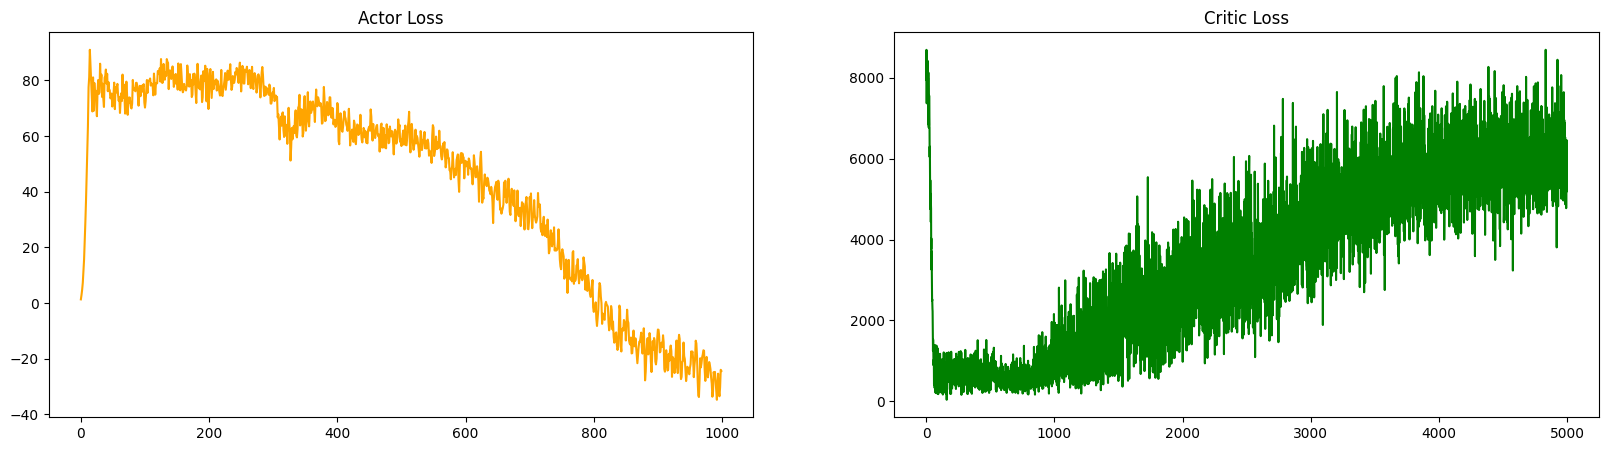

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(actor_losses, c='orange')
axs[0].set_title('Actor Loss')
axs[1].plot(critic_losses, c='g')
axs[1].set_title('Critic Loss')


In [43]:
# # Optional: Visualize a learned policy
# ll_env = gym.make('LunarLander-v2', continuous=True, render_mode='human')
# ll_env.metadata['render_fps'] =500
# policy_approximator = Actor(ll_env).to(device)
# policy_approximator.load_state_dict(torch.load('ll_checkpoints/epoch_2300.pt')['actor_state_dict'])
# # Visualize the learned policy
# state, _ = ll_env.reset()
# done = False
# while not done:
#   ll_env.render()
#   with torch.no_grad():
#     action = policy_approximator(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)).squeeze(0).cpu().numpy()
#     state, _, done, _, _ = ll_env.step(action)


In [44]:
ll_env.close()


c) Change from OU to Gaussian noise

Text(0.5, 1.0, 'Critic Loss')

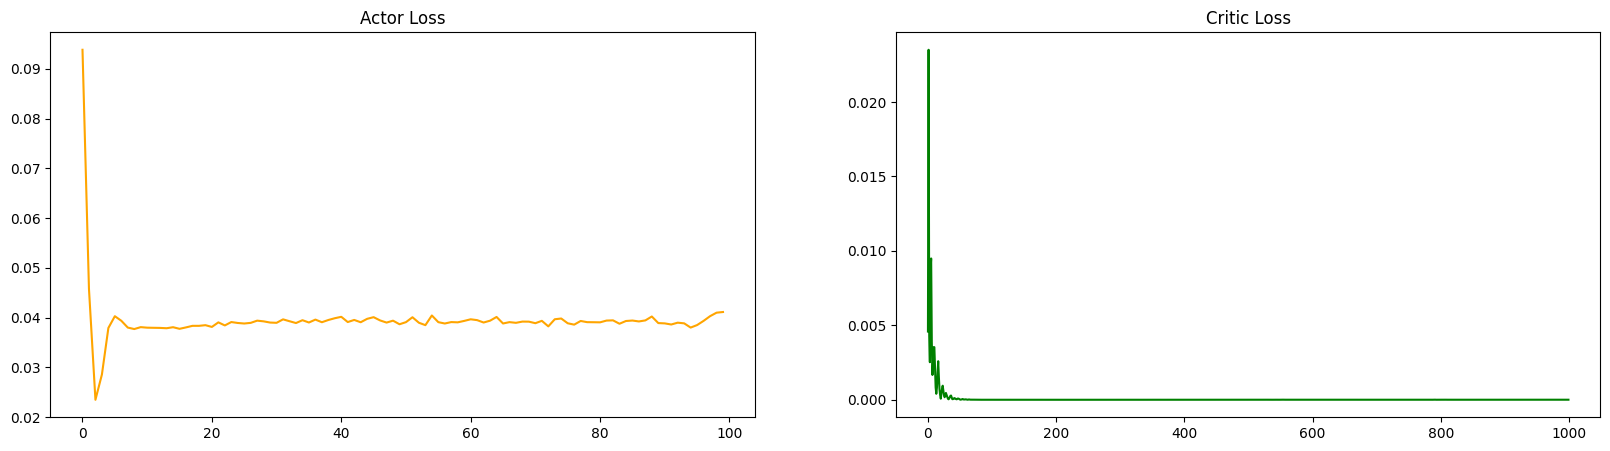

In [45]:
# Seeding
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mc_env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')
actor = Actor(mc_env).to(device)
critic = Critic(mc_env).to(device)
target_actor = Actor(mc_env).to(device)
target_critic = Critic(mc_env).to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-4)

# Noise param definitions
sigma = 0.5
mu = 0

# Training Loop
rb  = ReplayBuffer(mc_env)
state, _ = mc_env.reset(seed=42)
while len(rb) < 1000:
  with torch.no_grad():
    # action = actor(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)).squeeze(0).cpu().numpy()
    action = mc_env.action_space.sample()
    a_noise = np.random.normal(mu, sigma, action.shape)
    action = np.clip(action + a_noise, mc_env.action_space.low, mc_env.action_space.high)
    sprime, reward, done, _, _ = mc_env.step(action)
    rb.store(state, action, reward, sprime, done)
    state = sprime

# Training Loop
EPOCHS = 1000
batch = 64
policy_update = 10
checkpoint = 50
tau = 0.005
actor_losses = []
critic_losses = []
s, _ = mc_env.reset(seed=42)
for ep in range(1, (EPOCHS+1)):
  with torch.no_grad():
    s, _, _, _, _ = rb.sample_batch(1)
    a = actor(torch.tensor(s, dtype=torch.float, device=device)).cpu().numpy().squeeze(0)
    a_noise = np.random.normal(mu, sigma, action.shape)
    a = np.clip(a + a_noise, mc_env.action_space.low, mc_env.action_space.high)
    sprime, r, done, _, _ = mc_env.step(a)
    rb.store(s, a, r, sprime, done)

  s, a, r, sprime, done = rb.sample_batch(batch)
  s = torch.tensor(s, dtype=torch.float32, device=device)
  a = torch.tensor(a, dtype=torch.float32, device=device)
  r = torch.tensor(r, dtype=torch.float32, device=device)
  sprime = torch.tensor(sprime, dtype=torch.float32, device=device)
  done = torch.tensor(done, dtype=torch.float32, device=device)




  a_prime = target_actor(sprime)
  q_next_target = target_critic(sprime, a_prime)
  q_target = r + q_next_target * (1.0 - done) # Undiscounted

  q = critic(s, a)
  q_loss = F.mse_loss(q, q_target)

  critic_optimizer.zero_grad()
  q_loss.backward()
  critic_optimizer.step()
  critic_losses.append(q_loss.item())

  if ep % policy_update == 0:
    actor_loss = -critic(s, actor(s)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    actor_losses.append(actor_loss.item())
    # Saving checkpoints:
  # if ep % checkpoint == 0:
  #   torch.save({
  #     'epoch': ep,
  #     'actor_state_dict': actor.state_dict(),
  #     'critic_state_dict': critic.state_dict(),
  #     'actor_optimizer_state_dict': actor_optimizer.state_dict(),
  #     'critic_optimizer_state_dict': critic_optimizer.state_dict(),
  #     'actor_loss': actor_loss,
  #     'critic_loss': q_loss,
  #   }, f'mc_checkpoints/epoch_{ep}.pt')


  # Polyak averaging
    for weight, target_weight in zip(actor.parameters(), target_actor.parameters()):
      target_weight.data.copy_(tau * weight.data + (1.0 - tau) * target_weight.data)
    for weight, target_weight in zip(critic.parameters(), target_critic.parameters()):
      target_weight.data.copy_(tau * weight.data + (1.0 - tau) * target_weight.data)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(actor_losses, c='orange')
axs[0].set_title('Actor Loss')
axs[1].plot(critic_losses, c='g')
axs[1].set_title('Critic Loss')


Text(0.5, 1.0, 'Critic Loss')

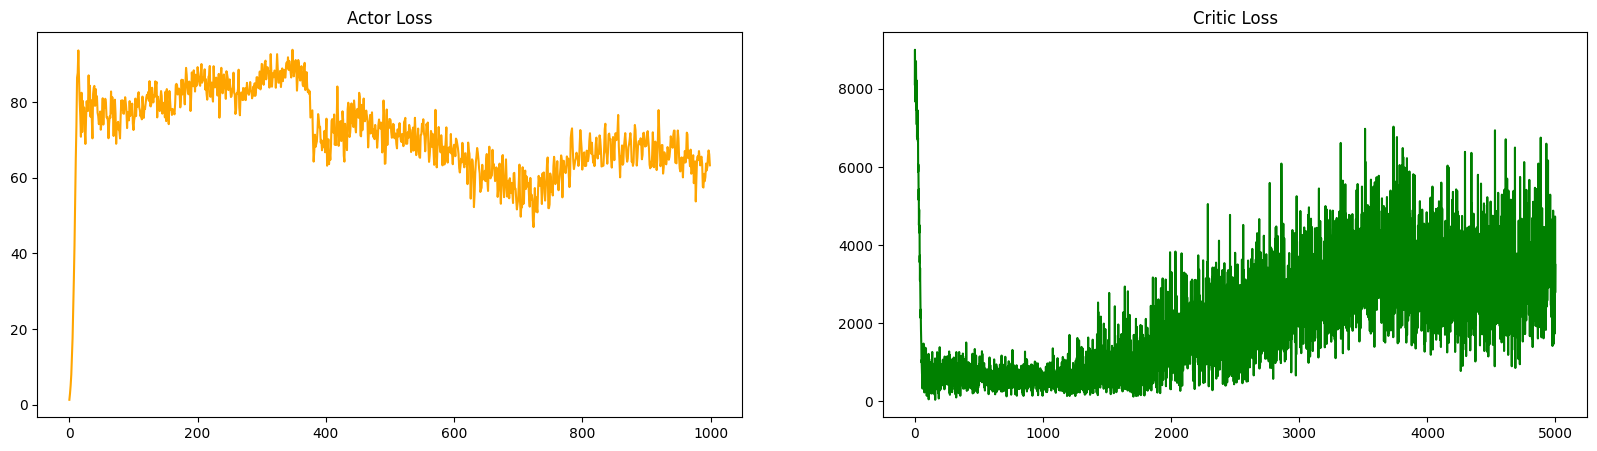

In [46]:
# Seeding
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ll_env = gym.make('LunarLander-v2', continuous = True, render_mode='rgb_array')
actor = Actor(ll_env).to(device)
critic = Critic(ll_env).to(device)
target_actor = Actor(ll_env).to(device)
target_critic = Critic(ll_env).to(device)
target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-4)

# Noise param definitions
theta = 0.05
sigma = 0.02
mu = 0.005

# Training Loop
rb  = ReplayBuffer(ll_env)
state, _ = ll_env.reset(seed=42)
while len(rb) < 1000:
  with torch.no_grad():
    # action = actor(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)).squeeze(0).cpu().numpy()
    action = ll_env.action_space.sample()
    a_noise = a_noise = np.random.normal(mu, sigma, action.shape)
    action = np.clip(action + a_noise, ll_env.action_space.low, ll_env.action_space.high)
    sprime, reward, done, _, _ = ll_env.step(action)
    rb.store(state, action, reward, sprime, done)
    state = sprime

# Training Loop
EPOCHS = 5000
batch = 64
policy_update = 5
checkpoint = 100
tau = 0.005
actor_losses = []
critic_losses = []
s, _ = ll_env.reset(seed=42)
for ep in range(1, (EPOCHS+1)):
  with torch.no_grad():
    s, _, _, _, _ = rb.sample_batch(1)
    a = actor(torch.tensor(s, dtype=torch.float, device=device)).cpu().numpy().squeeze(0)
    a_noise = a_noise = np.random.normal(mu, sigma, action.shape)
    a = np.clip(a + a_noise, ll_env.action_space.low, ll_env.action_space.high)
    sprime, r, done, _, _ = ll_env.step(a)
    rb.store(s, a, r, sprime, done)

  s, a, r, sprime, done = rb.sample_batch(batch)
  s = torch.tensor(s, dtype=torch.float32, device=device)
  a = torch.tensor(a, dtype=torch.float32, device=device)
  r = torch.tensor(r, dtype=torch.float32, device=device)
  sprime = torch.tensor(sprime, dtype=torch.float32, device=device)
  done = torch.tensor(done, dtype=torch.float32, device=device)




  a_prime = target_actor(sprime)
  q_next_target = target_critic(sprime, a_prime)
  q_target = r + 0.99*q_next_target * (1.0 - done) # gamma = 0.99

  q = critic(s, a)
  q_loss = F.mse_loss(q, q_target)

  critic_optimizer.zero_grad()
  q_loss.backward()
  critic_optimizer.step()
  critic_losses.append(q_loss.item())

  if ep % policy_update == 0:
    actor_loss = -critic(s, actor(s)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    actor_losses.append(actor_loss.item())
    # Saving checkpoints:
  if ep % checkpoint == 0:
    torch.save({
      'epoch': ep,
      'actor_state_dict': actor.state_dict(),
      'critic_state_dict': critic.state_dict(),
      'actor_optimizer_state_dict': actor_optimizer.state_dict(),
      'critic_optimizer_state_dict': critic_optimizer.state_dict(),
      'actor_loss': actor_loss,
      'critic_loss': q_loss,
    }, f'll_checkpoints/epoch_{ep}.pt')


  # Polyak averaging
    for weight, target_weight in zip(actor.parameters(), target_actor.parameters()):
      target_weight.data.copy_(tau * weight.data + (1.0 - tau) * target_weight.data)
    for weight, target_weight in zip(critic.parameters(), target_critic.parameters()):
      target_weight.data.copy_(tau * weight.data + (1.0 - tau) * target_weight.data)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(actor_losses, c='orange')
axs[0].set_title('Actor Loss')
axs[1].plot(critic_losses, c='g')
axs[1].set_title('Critic Loss')


There doesn't appear to be a significant difference between Gaussian and OU noises. It likely boils down to how large the noise actually ends up being at every action-approximation step.

Problem 2: Bandit Algorithms

a) Develop a bandit environment with k arms, each with a different mean reward. The reward distribution for each arm is Gaussian with a unit variance.

In [47]:
class BanditEnv:
  def __init__(self, k, means):
    self.n_arms = k
    self.rewards = means

  def pull(self,arm):
    return np.random.normal(self.rewards[arm], 1)


k = 10
means = [(-1)**i * i**2 for i in range(k)] # Randomly generate well-separated means for each arm, with alternating signs because the exploration looked nicer
bd = BanditEnv(k, means)


b) Implement the three algorithms that solve for Q*

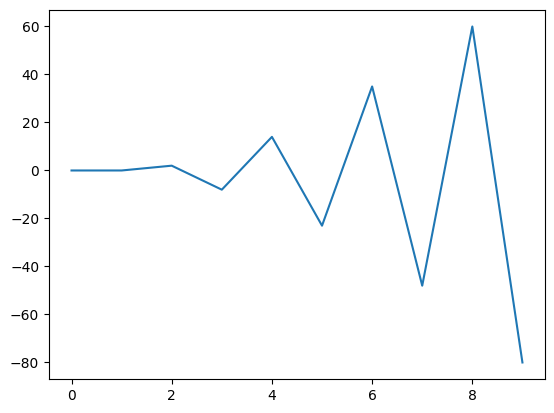

In [48]:
# Greedy Solution
M = 10
def greedy(bd, M=10, N=1000, return_rewards = False):
  Q = np.array([100 for i in range(bd.n_arms)])
  counts = np.zeros(bd.n_arms)
  rewards = np.zeros(N)
  regrets = np.zeros(N)
  round = 0
  for m in range(M):
    for arm in range(bd.n_arms):
      counts[arm] += 1
      reward = bd.pull(arm)
      Q[arm]+= (1/counts[arm])*(reward - Q[arm])
      # Keep track of rewards:
      rewards[round] = reward
      regrets[round] = np.max(Q) - reward
      round += 1
  for t in range(M*bd.n_arms, N):
    arm = np.argmax(Q)
    counts[arm] += 1
    reward = bd.pull(arm)
    Q[arm]+= (1/counts[arm])*(reward - Q[arm])
    rewards[round] = reward
    regrets[round] = np.max(Q) - reward
    round += 1
  return (Q, rewards, counts, regrets) if return_rewards else Q
plt.plot(greedy(bd))


Text(0.5, 1.0, 'Epsilon Greedy (0.01)')

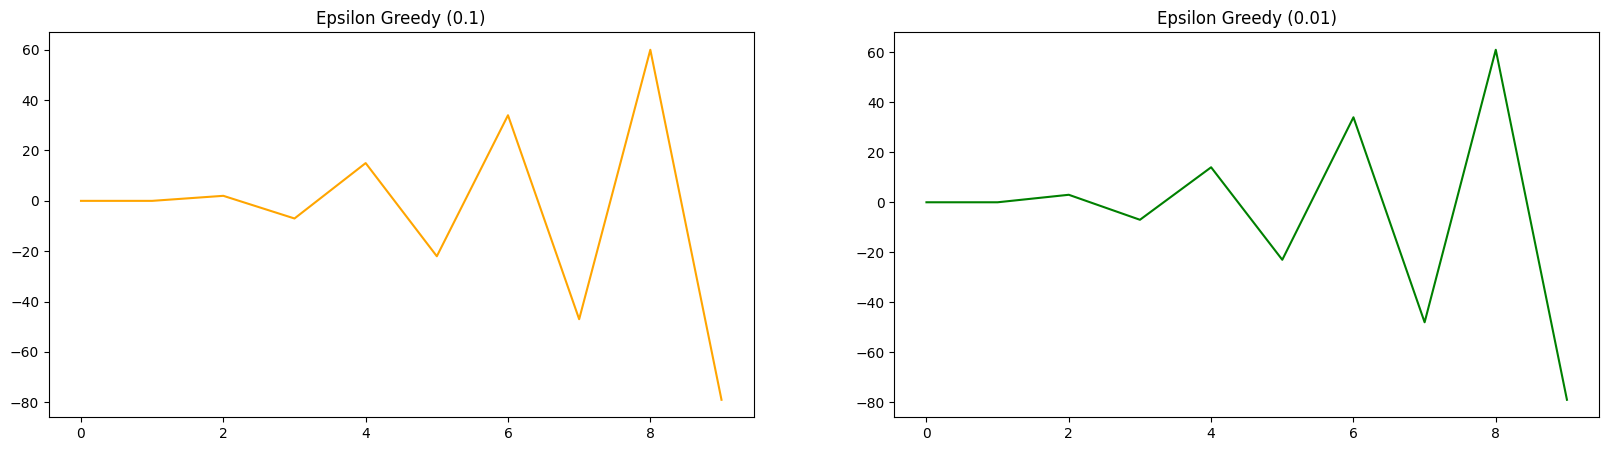

In [49]:
# Epsilon Greedy Solution
def epsilon_greedy(bd, M=10, N=1000, eps=0.1, return_rewards=False):
  epsilon_Q = np.array([100 for i in range(bd.n_arms)])
  counts = np.zeros(bd.n_arms)
  round = 0
  rewards = np.zeros(N)
  regrets = np.zeros(N)
  for m in range(M):
    for arm in range(bd.n_arms):
      counts[arm] += 1
      reward = bd.pull(arm)
      epsilon_Q[arm]+= (1/counts[arm])*(reward - epsilon_Q[arm])
      rewards[round] = reward
      regrets[round] = np.max(epsilon_Q) - reward
      round += 1
  for i in range(M*bd.n_arms, N):
    greedy = np.random.choice([0,1], p=[eps, 1-eps])
    if greedy:
      arm = np.argmax(epsilon_Q)
    else:
      arm = np.random.randint(0, bd.n_arms)
    counts[arm] += 1
    reward = bd.pull(arm)
    epsilon_Q[arm]+= (1/counts[arm])*(reward - epsilon_Q[arm])
    rewards[round] = reward
    regrets[round] = np.max(epsilon_Q) - reward
    round += 1
  return (epsilon_Q, rewards, counts, regrets) if return_rewards else epsilon_Q

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(epsilon_greedy(bd), c='orange')
axs[0].set_title('Epsilon Greedy (0.1)')
axs[1].plot(epsilon_greedy(bd, eps=0.01), c='g')
axs[1].set_title('Epsilon Greedy (0.01)')


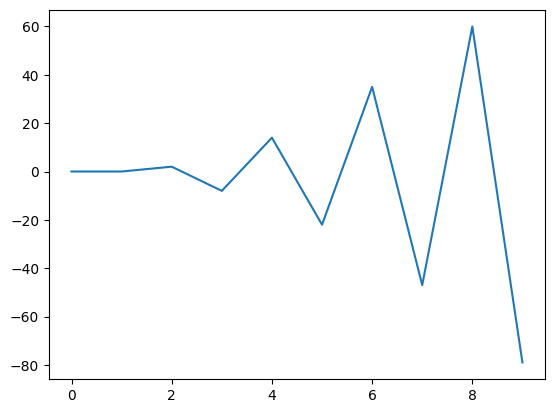

In [50]:
# Epsilon greedy with decay
def epsilon_greedy_decay(bd, M=10, N=1000, eps=0.1, r=0.99, return_rewards = False):
  epsilon_Q = np.array([100 for i in range(bd.n_arms)])
  counts = np.zeros(bd.n_arms)
  eps = 0.01
  r = 0.99
  rewards = np.zeros(N)
  regrets = np.zeros(N)
  round = 0
  for m in range(M):
    for arm in range(bd.n_arms):
      counts[arm] += 1
      reward = bd.pull(arm)
      epsilon_Q[arm]+= (1/counts[arm])*(reward - epsilon_Q[arm])
      rewards[round] = reward
      regrets[round] = np.max(epsilon_Q) - reward
      round += 1
  for i in range(M*bd.n_arms, N):
    greedy = np.random.choice([0,1], p=[eps, 1-eps])
    if greedy:
      arm = np.argmax(epsilon_Q)
    else:
      arm = np.random.randint(0, bd.n_arms)
    counts[arm] += 1
    reward = bd.pull(arm)
    epsilon_Q[arm]+= (1/counts[arm])*(reward - epsilon_Q[arm])
    eps *= r
    rewards[round] = reward
    regrets[round] = np.max(epsilon_Q) - reward
    round += 1
  return (epsilon_Q, rewards, counts, regrets) if return_rewards else epsilon_Q

plt.plot(epsilon_greedy_decay(bd))


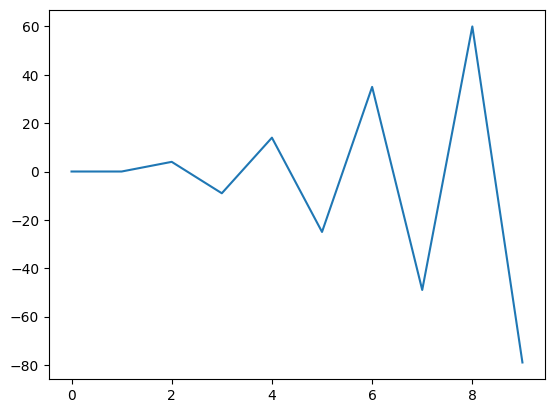

In [51]:
# UCB Solution
def ucb(bd, N=1000, return_rewards=False):
  ucb_Q = np.array([100 for i in range(bd.n_arms)])
  counts = np.zeros(bd.n_arms)
  round = 0
  rewards = np.zeros(N)
  regrets = np.zeros(N)
  for arm in range(bd.n_arms):
    counts[arm] += 1
    reward = bd.pull(arm)
    ucb_Q[arm]+= (1/counts[arm])*(reward - ucb_Q[arm])
    rewards[round] = reward
    regrets[round] = np.max(ucb_Q) - reward
    round += 1
  for t in range(bd.n_arms, N):
    ucb_coeff = np.sqrt(2*np.log(t+1)/counts)
    arm = np.argmax(ucb_Q + ucb_coeff)
    counts[arm] += 1
    reward = bd.pull(arm)
    ucb_Q[arm]+= (1/counts[arm])*(reward - ucb_Q[arm])
    rewards[round] = reward
    regrets[round] = np.max(ucb_Q) - reward
    round += 1

  return (ucb_Q, rewards, counts, regrets) if return_rewards else ucb_Q

plt.plot(ucb(bd))


c) Plot the average reward obtained by each algorithm as a function of the number of steps.


In [52]:
N = 1000
greedy_rewards = np.zeros(N)
eps_rewards = np.zeros(N)
eps_decay_rewards = np.zeros(N)
ucb_rewards = np.zeros(N)
for i in range(1, 101):
  _, greedy_sample, _, _ = greedy(bd, return_rewards=True)
  _, eps_sample, _, _ = epsilon_greedy(bd, return_rewards=True)
  _, eps_decay_sample, _, _ = epsilon_greedy_decay(bd, return_rewards=True)
  _, ucb_sample, _,_ = ucb(bd, return_rewards=True)
  greedy_rewards += (greedy_sample - greedy_rewards)/i
  eps_rewards += (eps_sample - eps_rewards)/i
  eps_decay_rewards += (eps_decay_sample - eps_decay_rewards)/i
  ucb_rewards += (ucb_sample - ucb_rewards)/i


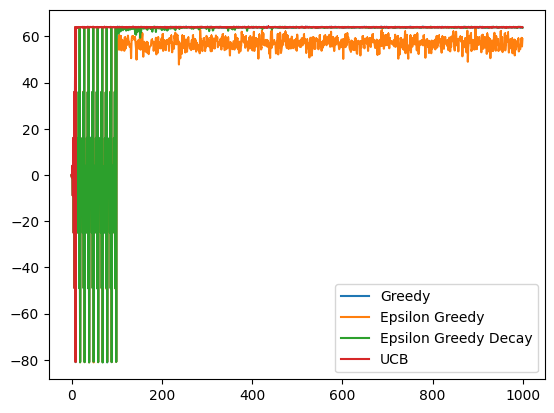

In [53]:
plt.plot(greedy_rewards, label='Greedy', marker=',')
plt.plot(eps_rewards, label='Epsilon Greedy', marker=',')
plt.plot(eps_decay_rewards, label='Epsilon Greedy Decay', marker=',')
plt.plot(ucb_rewards, label='UCB', marker=',')
plt.legend()


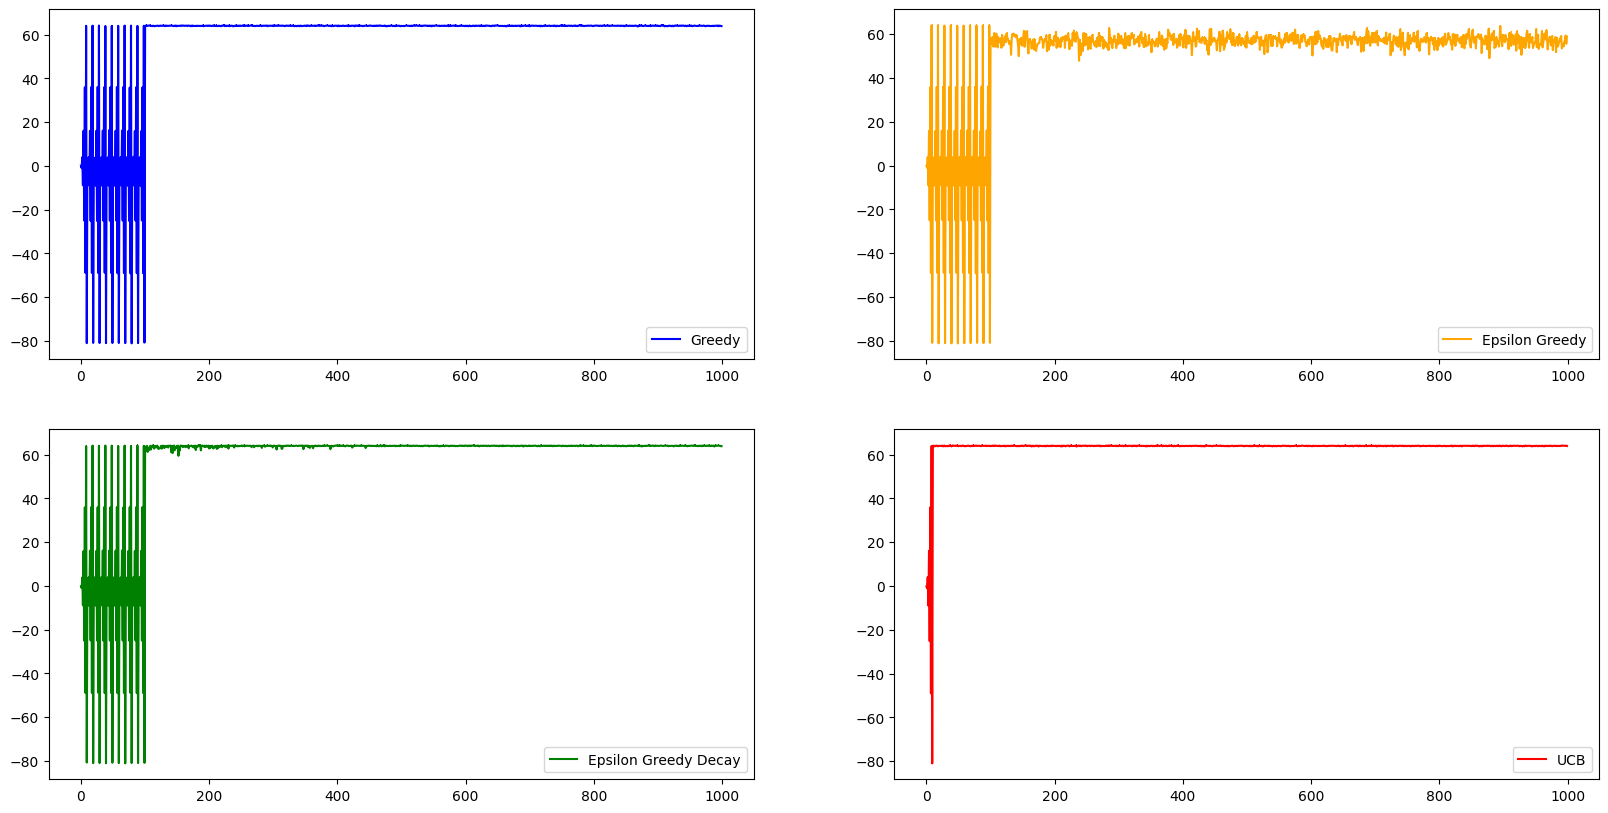

In [54]:
# Plotting in different graphs for clarity
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(greedy_rewards, label='Greedy', marker=',', c='b')
axs[0, 0].legend()
axs[0, 1].plot(eps_rewards, label='Epsilon Greedy', marker=',', c='orange')
axs[0, 1].legend()
axs[1, 0].plot(eps_decay_rewards, label='Epsilon Greedy Decay', marker=',', c='g')
axs[1, 0].legend()
axs[1, 1].plot(ucb_rewards, label='UCB', marker=',', c='r')
axs[1, 1].legend()


d) Plot the number of times each arm is pulled, on average

In [55]:
# Computing average counts:
greedy_counts = np.zeros(bd.n_arms)
eps_counts = np.zeros(bd.n_arms)
eps_decay_counts = np.zeros(bd.n_arms)
ucb_counts = np.zeros(bd.n_arms)
for i in range(1, 101):
  _, _, greedy_sample, _ = greedy(bd, return_rewards=True)
  _, _, eps_sample, _ = epsilon_greedy(bd, return_rewards=True)
  _, _, eps_decay_sample, _ = epsilon_greedy_decay(bd, return_rewards=True)
  _, _, ucb_sample, _ = ucb(bd, return_rewards=True)
  greedy_counts += (greedy_sample - greedy_counts)/i
  eps_counts += (eps_sample - eps_counts)/i
  eps_decay_counts += (eps_decay_sample - eps_decay_counts)/i
  ucb_counts += (ucb_sample - ucb_counts)/i


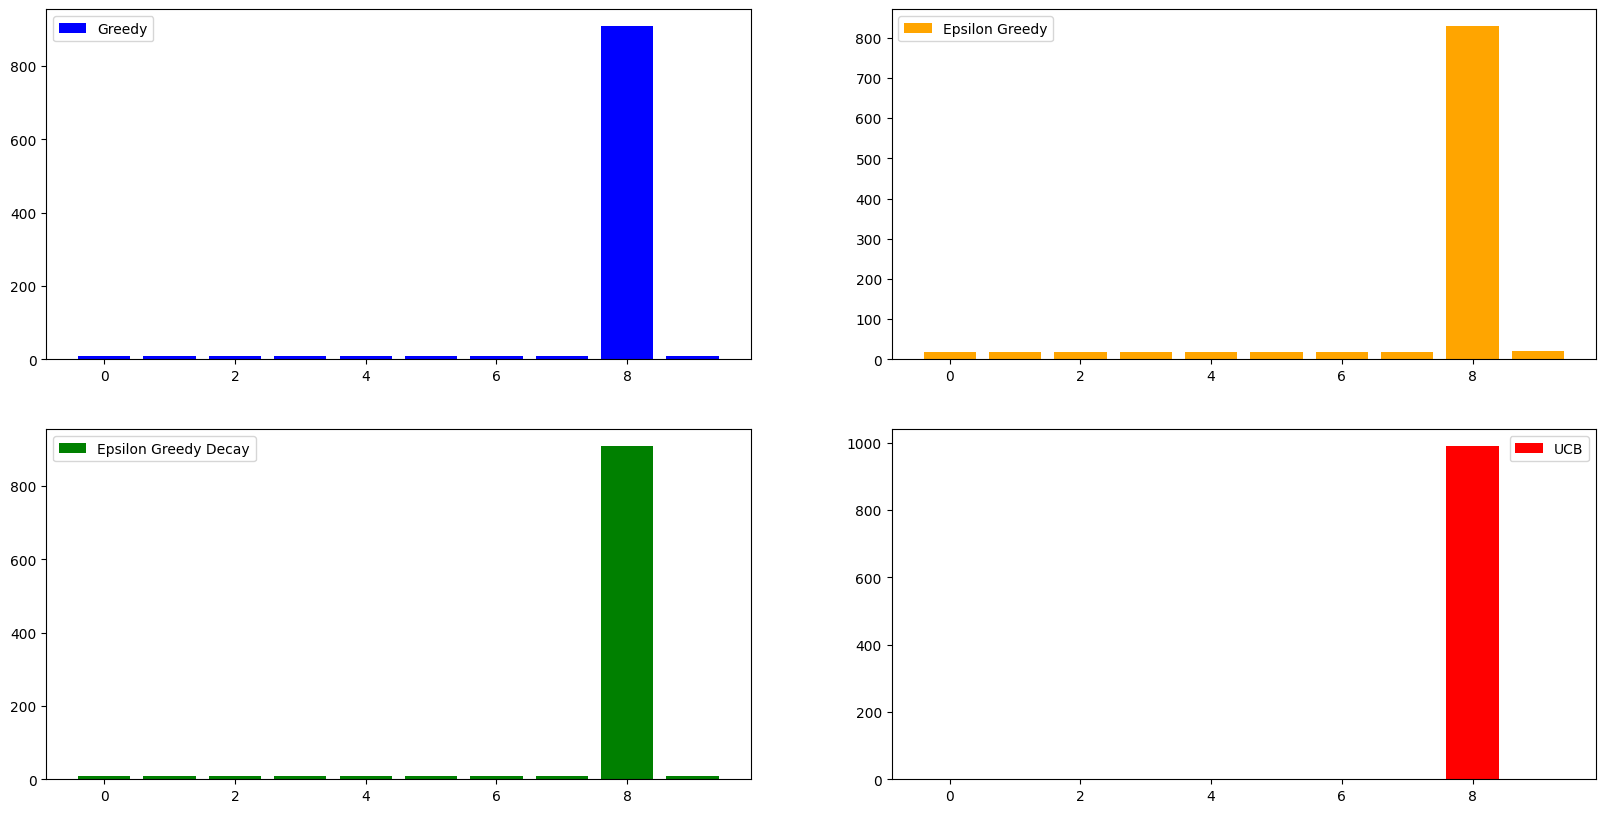

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].bar(range(bd.n_arms), greedy_counts, label='Greedy', color='b')
axs[0, 0].legend()
axs[0, 1].bar(range(bd.n_arms), eps_counts, label='Epsilon Greedy', color='orange')
axs[0, 1].legend()
axs[1, 0].bar(range(bd.n_arms), eps_decay_counts, label='Epsilon Greedy Decay', color='g')
axs[1, 0].legend()
axs[1, 1].bar(range(bd.n_arms), ucb_counts, label='UCB', color='r')
axs[1, 1].legend()


e) Plot the average regrets for each algorithm as a function of the number of rounds.

In [57]:
# Charting out regrets
N = 1000
greedy_regrets = np.zeros(N)
eps_regrets = np.zeros(N)
eps_decay_regrets = np.zeros(N)
ucb_regrets = np.zeros(N)
for i in range(1, 101):
  _, _, _, greedy_sample = greedy(bd, return_rewards=True)
  _, _, _, eps_sample = epsilon_greedy(bd, return_rewards=True)
  _, _, _, eps_decay_sample = epsilon_greedy_decay(bd, return_rewards=True)
  _, _, _, ucb_sample = ucb(bd, return_rewards=True)
  greedy_regrets += (greedy_sample - greedy_regrets)/i
  eps_regrets += (eps_sample - eps_regrets)/i
  eps_decay_regrets += (eps_decay_sample - eps_decay_regrets)/i
  ucb_regrets += (ucb_sample - ucb_regrets)/i


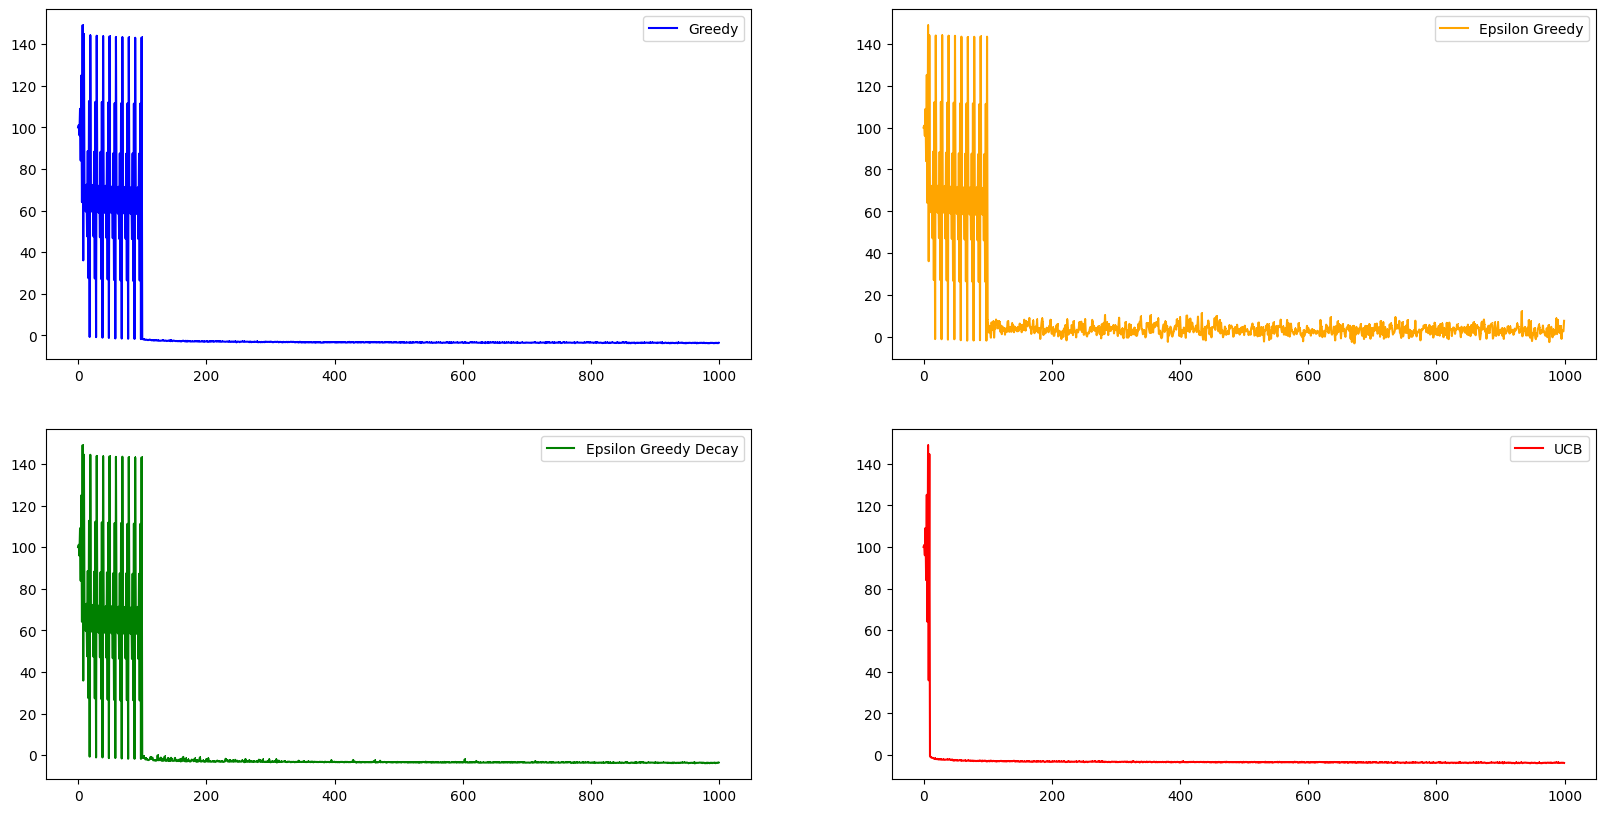

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(greedy_regrets, label='Greedy', marker=',', c='b')
axs[0, 0].legend()
axs[0, 1].plot(eps_regrets, label='Epsilon Greedy', marker=',', c='orange')
axs[0, 1].legend()
axs[1, 0].plot(eps_decay_regrets, label='Epsilon Greedy Decay', marker=',', c='g')
axs[1, 0].legend()
axs[1, 1].plot(ucb_regrets, label='UCB', marker=',', c='r')
axs[1, 1].legend()


f) Which is better?

A) From the above plots, it's clear that when the distribution of rewards is very distinct across arms, with one arm clearly standing out as the most optimal one to pull to minimize regret, UCB wins out as the best bandit algorithm.

g) Repeat the above analysis, but this time have the best and second best arm have their reward distributions be close

In [59]:
bd.rewards[6] = 63.999
# Going from [0, -1, 4, -9, 16, -25, 36, -49, 64, -81] to [0, -1, 4, -9, 16, -25, 63.999, -49, 64, -81]
N = 1000
greedy_rewards = np.zeros(N)
eps_rewards = np.zeros(N)
eps_decay_rewards = np.zeros(N)
ucb_rewards = np.zeros(N)
for i in range(1, 101):
  _, greedy_sample, _, _ = greedy(bd, return_rewards=True)
  _, eps_sample, _, _ = epsilon_greedy(bd, return_rewards=True)
  _, eps_decay_sample, _, _ = epsilon_greedy_decay(bd, return_rewards=True)
  _, ucb_sample, _,_ = ucb(bd, return_rewards=True)
  greedy_rewards += (greedy_sample - greedy_rewards)/i
  eps_rewards += (eps_sample - eps_rewards)/i
  eps_decay_rewards += (eps_decay_sample - eps_decay_rewards)/i
  ucb_rewards += (ucb_sample - ucb_rewards)/i

# Computing average counts:
greedy_counts = np.zeros(bd.n_arms)
eps_counts = np.zeros(bd.n_arms)
eps_decay_counts = np.zeros(bd.n_arms)
ucb_counts = np.zeros(bd.n_arms)
for i in range(1, 101):
  _, _, greedy_sample, _ = greedy(bd, return_rewards=True)
  _, _, eps_sample, _ = epsilon_greedy(bd, return_rewards=True)
  _, _, eps_decay_sample, _ = epsilon_greedy_decay(bd, return_rewards=True)
  _, _, ucb_sample, _ = ucb(bd, return_rewards=True)
  greedy_counts += (greedy_sample - greedy_counts)/i
  eps_counts += (eps_sample - eps_counts)/i
  eps_decay_counts += (eps_decay_sample - eps_decay_counts)/i
  ucb_counts += (ucb_sample - ucb_counts)/i

# Charting out regrets
N = 1000
greedy_regrets = np.zeros(N)
eps_regrets = np.zeros(N)
eps_decay_regrets = np.zeros(N)
ucb_regrets = np.zeros(N)
for i in range(1, 101):
  _, _, _, greedy_sample = greedy(bd, return_rewards=True)
  _, _, _, eps_sample = epsilon_greedy(bd, return_rewards=True)
  _, _, _, eps_decay_sample = epsilon_greedy_decay(bd, return_rewards=True)
  _, _, _, ucb_sample = ucb(bd, return_rewards=True)
  greedy_regrets += (greedy_sample - greedy_regrets)/i
  eps_regrets += (eps_sample - eps_regrets)/i
  eps_decay_regrets += (eps_decay_sample - eps_decay_regrets)/i
  ucb_regrets += (ucb_sample - ucb_regrets)/i


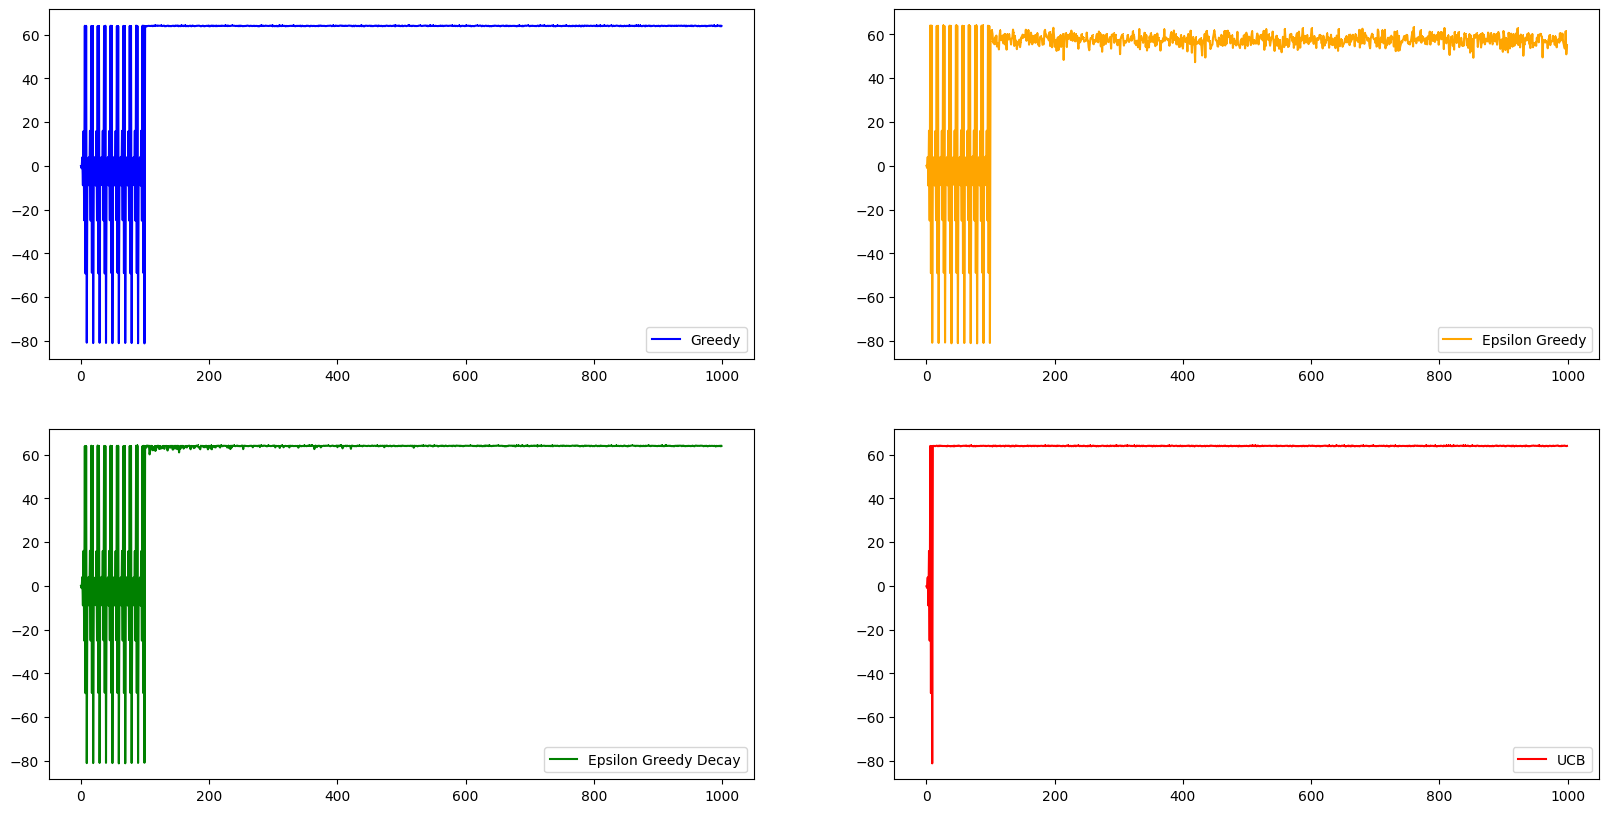

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(greedy_rewards, label='Greedy', marker=',', c='b')
axs[0, 0].legend()
axs[0, 1].plot(eps_rewards, label='Epsilon Greedy', marker=',', c='orange')
axs[0, 1].legend()
axs[1, 0].plot(eps_decay_rewards, label='Epsilon Greedy Decay', marker=',', c='g')
axs[1, 0].legend()
axs[1, 1].plot(ucb_rewards, label='UCB', marker=',', c='r')
axs[1, 1].legend()


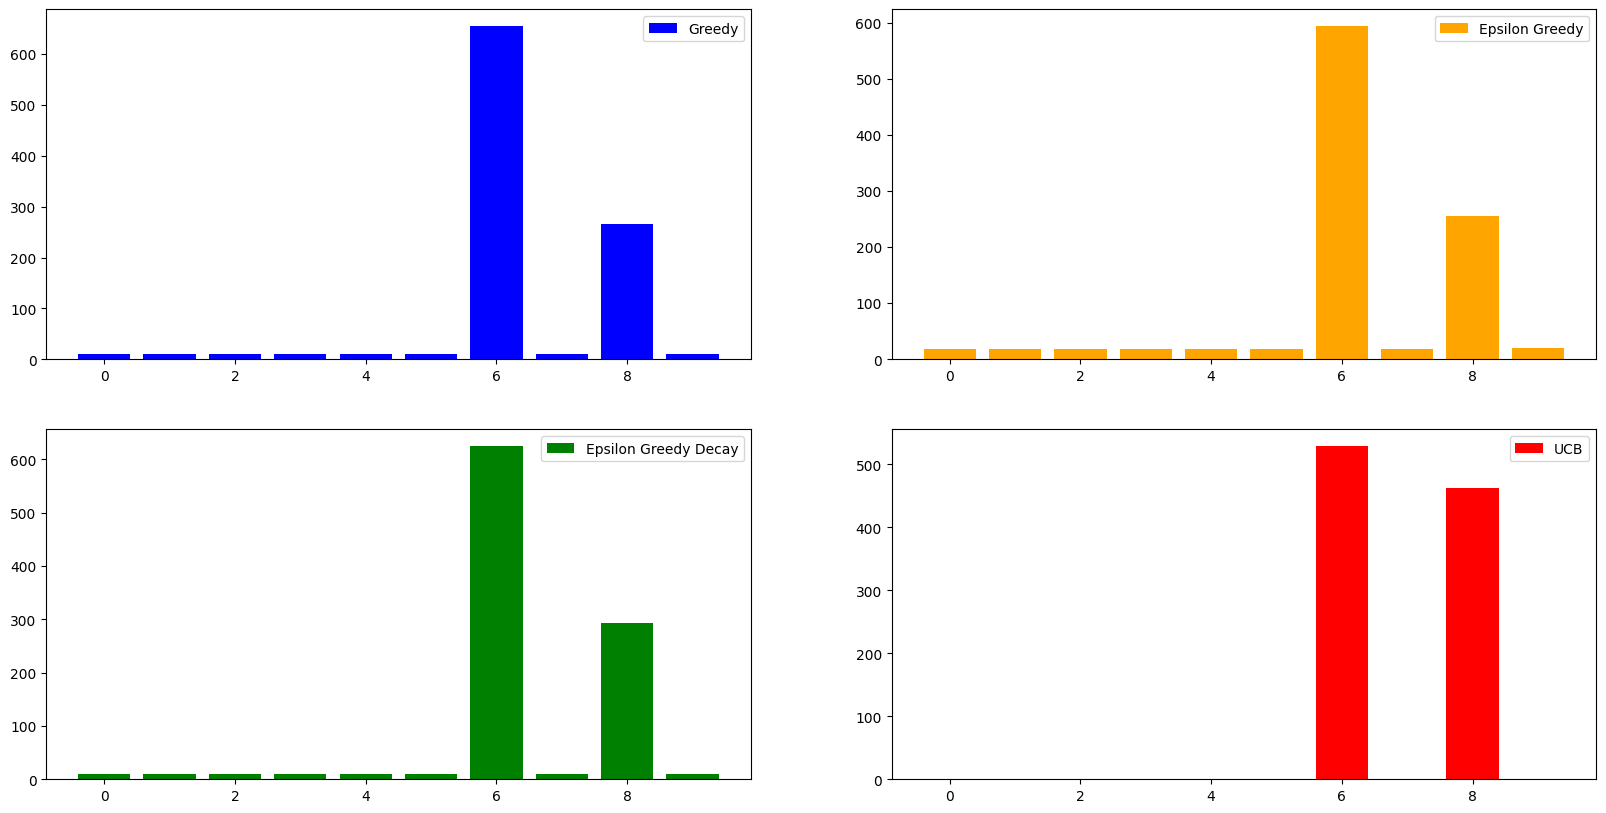

In [61]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].bar(range(bd.n_arms), greedy_counts, label='Greedy', color='b')
axs[0, 0].legend()
axs[0, 1].bar(range(bd.n_arms), eps_counts, label='Epsilon Greedy', color='orange')
axs[0, 1].legend()
axs[1, 0].bar(range(bd.n_arms), eps_decay_counts, label='Epsilon Greedy Decay', color='g')
axs[1, 0].legend()
axs[1, 1].bar(range(bd.n_arms), ucb_counts, label='UCB', color='r')
axs[1, 1].legend()


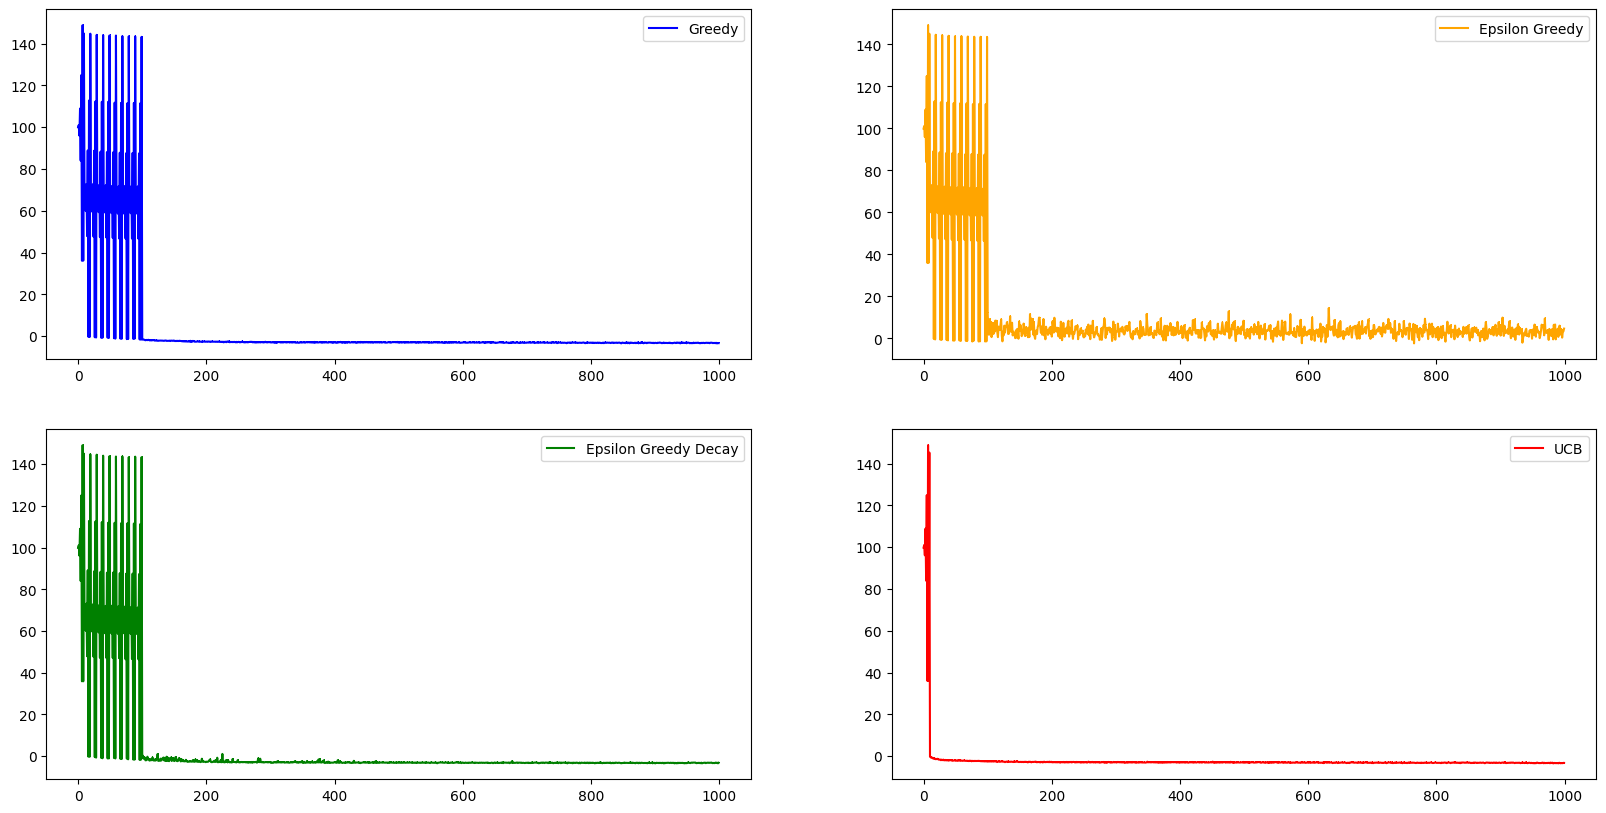

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].plot(greedy_regrets, label='Greedy', marker=',', c='b')
axs[0, 0].legend()
axs[0, 1].plot(eps_regrets, label='Epsilon Greedy', marker=',', c='orange')
axs[0, 1].legend()
axs[1, 0].plot(eps_decay_regrets, label='Epsilon Greedy Decay', marker=',', c='g')
axs[1, 0].legend()
axs[1, 1].plot(ucb_regrets, label='UCB', marker=',', c='r')
axs[1, 1].legend()


When the two best arms are close enough, the exploration parts of each of the greedy variants of result in the second best being visited more often than the best arm, leading to a higher regret as well as slower regret convergence. UCB still stands as the best algorithm, but only because it visits both arms in roughly equal proportion, making it better than the greedy variants, but still not as good as an algorithm that would pick the best arm every time.